In [3]:
import os, sys
import pandas as pd
import numpy as np
import math
import random
from typing import DefaultDict
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, roc_curve, auc
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning

from IPython.display import display

In [4]:
ROOT = "/content"
data_file = os.path.join(ROOT, "data/Task3and4_Loan_Data.csv")
if not os.path.exists(data_file):
    print("File not found")
    sys.exit(1)

df = pd.read_csv(data_file)

## **Exploratory Data Analysis**

In [87]:
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


In [88]:
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [89]:
df.sort_values(by='loan_amt_outstanding', ascending=False).head(5)

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
3639,8927585,1,10750.67781,16953.237650,148412.1805,6,657,0
890,1773897,2,10467.73206,20825.284860,130912.3875,5,671,0
1997,6597386,5,10210.74669,33515.971170,107870.3896,2,649,1
6526,4110450,0,10190.83866,3717.620173,117370.6607,4,675,0
7658,1605704,1,10006.51554,16251.289160,132504.2350,5,670,0


In [90]:
# sheet = sheets.InteractiveSheet(df=df)

In [91]:
# explore correlation of each variable with defaulting
# heatmap of correlation matrix, exclude customer_id as irrelevant
df.drop(columns=['customer_id']).corr().style.background_gradient(cmap=sns.diverging_palette(250, 30, s=75, l=65, center="dark", as_cmap=True))

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
credit_lines_outstanding,1.000000,0.080249,0.852210,0.022272,-0.087900,-0.258177,0.862815
loan_amt_outstanding,0.080249,1.000000,0.397403,0.835815,-0.158416,-0.031373,0.098978
total_debt_outstanding,0.852210,0.397403,1.000000,0.394397,-0.174353,-0.232246,0.758868
income,0.022272,0.835815,0.394397,1.000000,0.001814,-0.010528,0.016309
years_employed,-0.087900,-0.158416,-0.174353,0.001814,1.000000,0.255873,-0.284506
fico_score,-0.258177,-0.031373,-0.232246,-0.010528,0.255873,1.000000,-0.324515
default,0.862815,0.098978,0.758868,0.016309,-0.284506,-0.324515,1.000000


#### We can't state that high absolute values in the default column mean that one of those six features cause defaults. But there is strong correlation when the absolute value is close to 1.

#### - **Strong Positive Correlation:** The variables `credit_lines_outstanding` and `total_debt_outstanding` have a strong positive correlation with `default`.
#### - **Inverse Correlation:** The variables `years_employed` and `fico_score` suggest high values result in lower `default` rates.
#### - **Weak Relation:** Variables like `income` and `loan_amt_outstanding` seem to have low influence on loan `default`.

#### These observations can guide our feature selection.

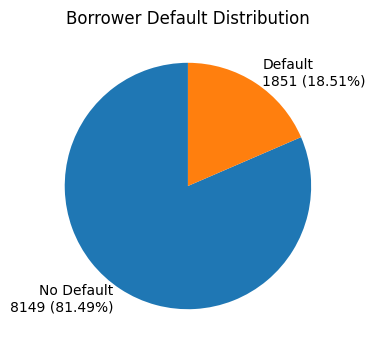

In [92]:
# # pie chart of borrower default distribution
no_defaults =  df[df['default'] == 0]
yes_defaults = df[df['default'] == 1]

no_default_ct, yes_default_ct, total_borrowers = len(no_defaults), len(yes_defaults), len(df)

# # Create labels with both percentage and count
labels = [f'No Default\n{no_default_ct} ({no_default_ct/total_borrowers:.2%})',
          f'Default\n{yes_default_ct} ({yes_default_ct/total_borrowers:.2%})']

plt.figure(figsize=(6, 4))
plt.pie(df['default'].value_counts(), labels=labels, autopct='', startangle=90)
plt.title('Borrower Default Distribution')
plt.show()

In [10]:
# All features
features = [
    'credit_lines_outstanding',
    'loan_amt_outstanding',
    'total_debt_outstanding',
    'income',
    'years_employed',
    'fico_score'
]
target = 'default'

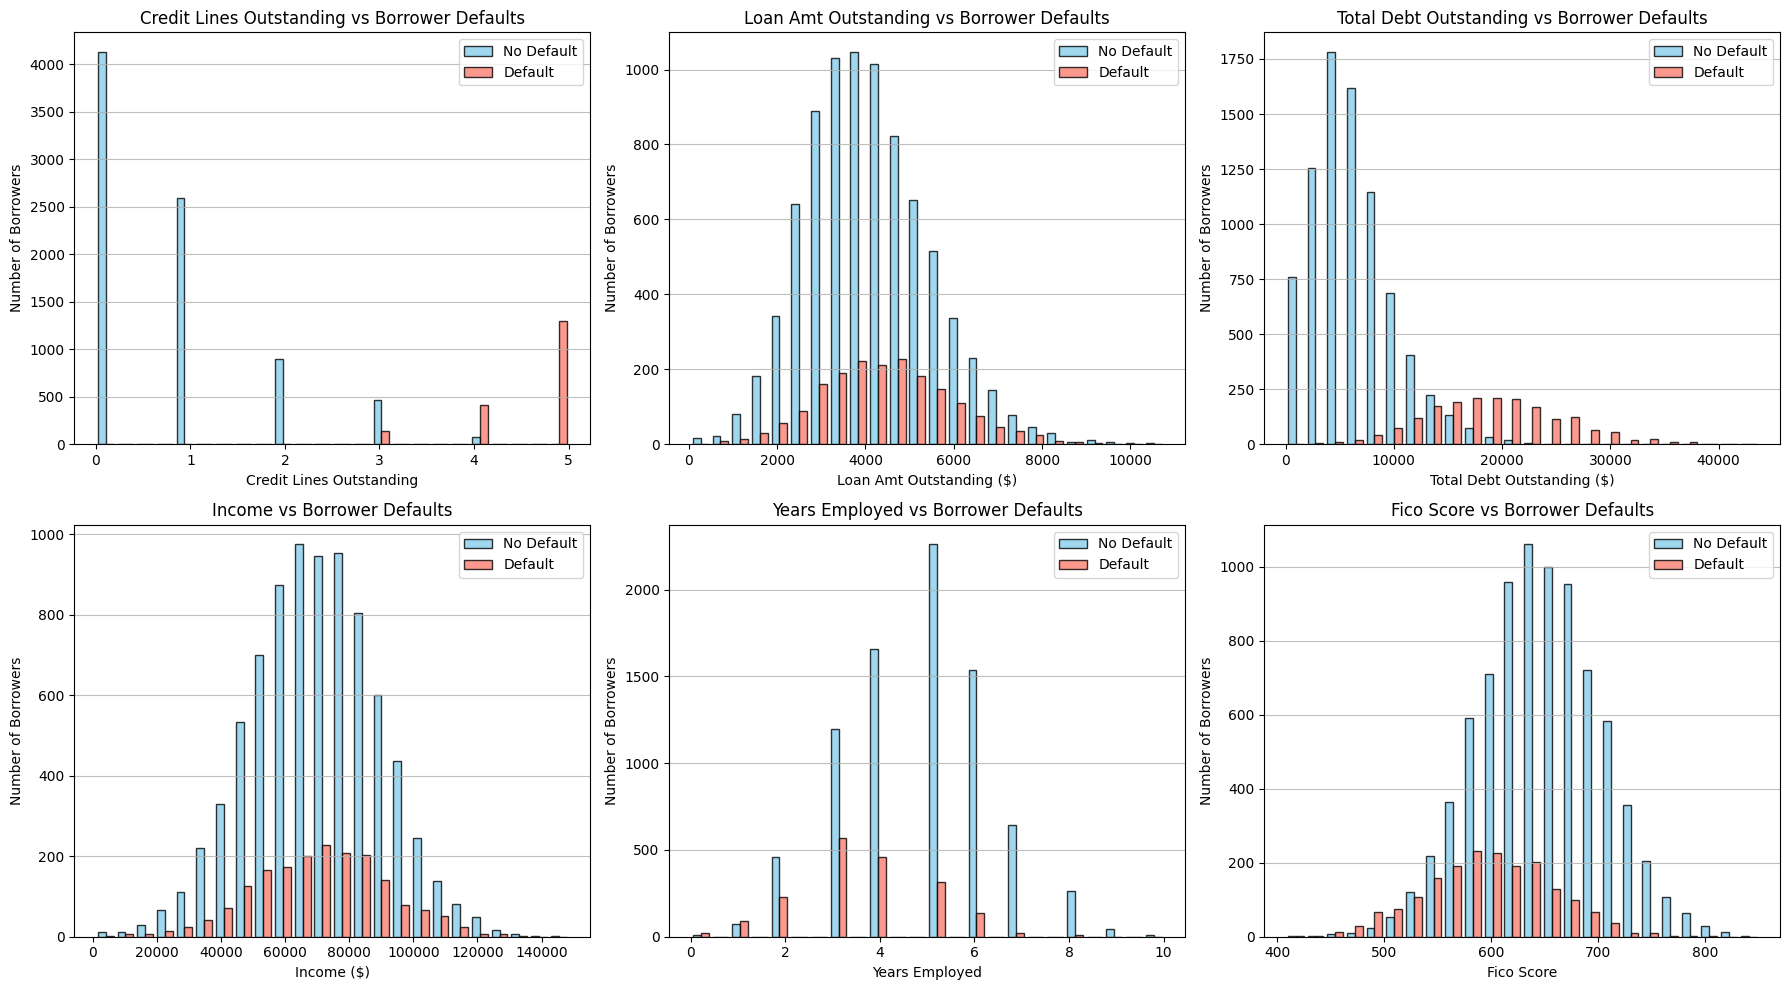

In [11]:
# Make 6 plots of each feature compared with default {0,1} to visualize correlation

# add dollar sign to xlabel if a money unit
features_dollar_sign = [
    'loan_amt_outstanding',
    'total_debt_outstanding',
    'income'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10)) # 2 rows 3 columns
axes = axes.flatten()

# Loop through each feature and create histograms
for idx, feature in enumerate(features):
    ax = axes[idx]

    no_defaults =  df[df['default'] == 0][feature]
    yes_defaults = df[df['default'] == 1][feature]

    bins = np.linspace(start=df[feature].min(), stop=df[feature].max(), num=25)

    # Plot histograms
    ax.hist(
        [no_defaults, yes_defaults],
        bins=bins,
        label=['No Default', 'Default'],
        color=['skyblue', 'salmon'],
        alpha=0.8,
        edgecolor='black',
        stacked=False
    )

    # Set titles and labels
    ax.set_title(f'{feature.replace("_", " ").title()} vs Borrower Defaults')
    if feature in features_dollar_sign:
        ax.set_xlabel(f'{feature.replace("_", " ").title()} ($)')
    else:
        ax.set_xlabel(feature.replace("_", " ").title())
    ax.set_ylabel('Number of Borrowers')

    ax.legend()
    ax.grid(axis='y', alpha=0.8)

# Remove any unused subplots (if features list has less than total subplots)
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### These charts confirm our analysis of the correlation matrix heatmap and aid feature selection.

#### Besides the obvious, it appears as if higher loan amount and higher incomes increase default rate slightly. Higher income wouldn't intuitively increase default rate except those borrowers could be more likely to take out loans. Income and savings rate is not available in the data here but is not necessarily correlated. Higher income borrowers could be more risk-on given their ability to pay back capital quicker or draw on existing assets. Speculation - so let us see what the model reveals.

## **Model Evaluation and Selection**

In [12]:
# Common variables for all models
X, y = df[features], df[target]

# Split the data (use the same split for all models)
X_train_init, X_test_init, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalize the features in the inclusive range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_init)
X_test_scaled = scaler.transform(X_test_init)

# Convert back to DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=features)
X_test = pd.DataFrame(X_test_scaled, columns=features)

In [8]:
def train_models_store_results(features: list, target: str, model_names: list, iteration_values: list) -> pd.DataFrame:
    """
    train the dict of models on the range of the iteration values to see
    what models is best for this task and which iteration value is best
    and which to eliminate if poor performance

    models supported
    models = ['Logistic Regression', 'Support Vector Machine', 'Random Forest', 'Gradient Boosting', 'XGBoost']
    """
    # check if X, y, X_train, X_test, y_train, y_test have all been created before proceeding
    if any(var is None for var in [X, y, X_train, X_test, y_train, y_test]):
        print("X, y, X_train, X_test, y_train, y_test need to be created before executing this function.")
        return None

    iteration_values.sort()
    results_list = []

    for iteration_value in iteration_values:

        # Create model dict
        models = {}
        if 'Logistic Regression' in model_names:
            models['Logistic Regression'] = LogisticRegression(max_iter=iteration_value, random_state=42)
        if 'Support Vector Machine' in model_names:
            models['Support Vector Machine'] = SVC(probability=True, max_iter=iteration_value, random_state=42)
        if 'Random Forest' in model_names:
            models['Random Forest'] = RandomForestClassifier(n_estimators=iteration_value, random_state=42)
        if 'Gradient Boosting' in model_names:
            models['Gradient Boosting'] = GradientBoostingClassifier(n_estimators=iteration_value, random_state=42)
        if 'XGBoost' in model_names:
            models['XGBoost'] = XGBClassifier(n_estimators=iteration_value, random_state=42, eval_metric='logloss')

        for model_name, model in models.items():
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                try:
                    model.fit(X_train, y_train)
                    convergence_warning = any([issubclass(warning.category, ConvergenceWarning) for warning in w])

                    if convergence_warning:
                        # If convergence warning occurred, set metrics to zero
                        accuracy, precision, recall, f1, roc_auc = 0, 0, 0, 0, 0
                        print(f"Convergence warning occurred for model {model_name} with iteration value {iteration_value}")
                    else:
                        # Predict on test data
                        y_pred = model.predict(X_test)
                        y_pred_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
                        # Evaluate the model
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred, zero_division='warn')
                        recall = recall_score(y_test, y_pred, zero_division='warn')
                        f1 = f1_score(y_test, y_pred, zero_division='warn')
                        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0
                except Exception as e:
                    # If an exception occurs, set metrics to zero
                    accuracy, precision, recall, f1, roc_auc = 0, 0, 0, 0, 0
                    print(f"Error occurred for model {model_name} with iteration value {iteration_value}: {e}")

                result = {
                    'model_name': model_name,
                    'iteration_value': iteration_value,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'roc_auc': roc_auc
                }
                results_list.append(result)

    results_df = pd.DataFrame(results_list)

    return results_df

In [9]:
def plot_model_comparison(results_df: pd.DataFrame, iteration_values: list) -> None:
    """
    Plot the scores of 5 models vs each other
    Use 3 n_iterations / n_estimators values to see which value is best to use
    """
    metrics=['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

    if type(iteration_values) != list or not (0 < len(iteration_values) <= 3):
        raise ValueError("iteration_values should have exactly 1 to 3 values.")
        return

    iteration_colors = {}
    iteration_colors[iteration_values[0]] = '#1f77b4'
    if len(iteration_values) >= 2:
        iteration_colors[iteration_values[1]] = '#ff7f0e'
    if len(iteration_values) == 3:
        iteration_colors[iteration_values[2]] = '#2ca02c'

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(28, 6), sharey=False)
    handles_list, labels_list = [], []

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        # Pivot the DataFrame for the current metric
        df_metric = results_df.pivot_table(
            index='model_name',
            columns='iteration_value',
            values=metric
        ).reindex(results_df['model_name'].unique())

        x = np.arange(len(df_metric.index))  # The label locations
        total_width = 0.8
        num_bars = len(iteration_values)
        bar_width = total_width / num_bars

        # Plot bars for each iteration value, side by side
        for i, iteration_value in enumerate(iteration_values):
            # Get the data for this iteration value
            y = df_metric[iteration_value]

            # Calculate the position of the bars
            offset = (i - (num_bars - 1) / 2) * bar_width
            bars = ax.bar(x + offset, y,
                            width=bar_width,
                            color=iteration_colors[iteration_value],
                            edgecolor='black',
                            linewidth=0.5)
            if idx == 0:
                # Collect handles and labels for the legend
                handles_list.append(bars[0])
                labels_list.append(f'{iteration_value} Iterations')

        # Set chart title and labels
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_xlabel('Model')
        if idx == 0: ax.set_ylabel('Score')

        ax.set_xticks(x)
        ax.set_xticklabels(df_metric.index, rotation=45, ha='right')

        # Adjust y-axis limits to zoom in on the differences
        # FIXME: have flexible scaling so that bars are in the middle of the ylimits
        if metric == 'roc_auc':     ax.set_ylim(0.9994, 1.0)
        elif metric == 'f1_score':  ax.set_ylim(0.96, 1.0)
        elif metric == 'recall':    ax.set_ylim(0.95, 1.0)
        elif metric == 'precision': ax.set_ylim(0.97, 1.0)
        elif metric == 'accuracy':  ax.set_ylim(0.985, 1.0)

        ax.grid(axis='y')

    # Add a joint title for the figure
    fig.suptitle('Model Performance Metrics Across Different Iterations', fontsize=16)
    fig.legend(handles_list, labels_list, title='Iterations', loc='lower left', bbox_to_anchor=(0.1, -0.2), ncol=3)
    # Adjust layout to make room for the legend and title
    plt.subplots_adjust(top=0.88, bottom=0.15, wspace=0.3)
    plt.show()

Convergence warning occurred for model Logistic Regression with iteration value 10
Convergence warning occurred for model Support Vector Machine with iteration value 10
Convergence warning occurred for model Support Vector Machine with iteration value 100


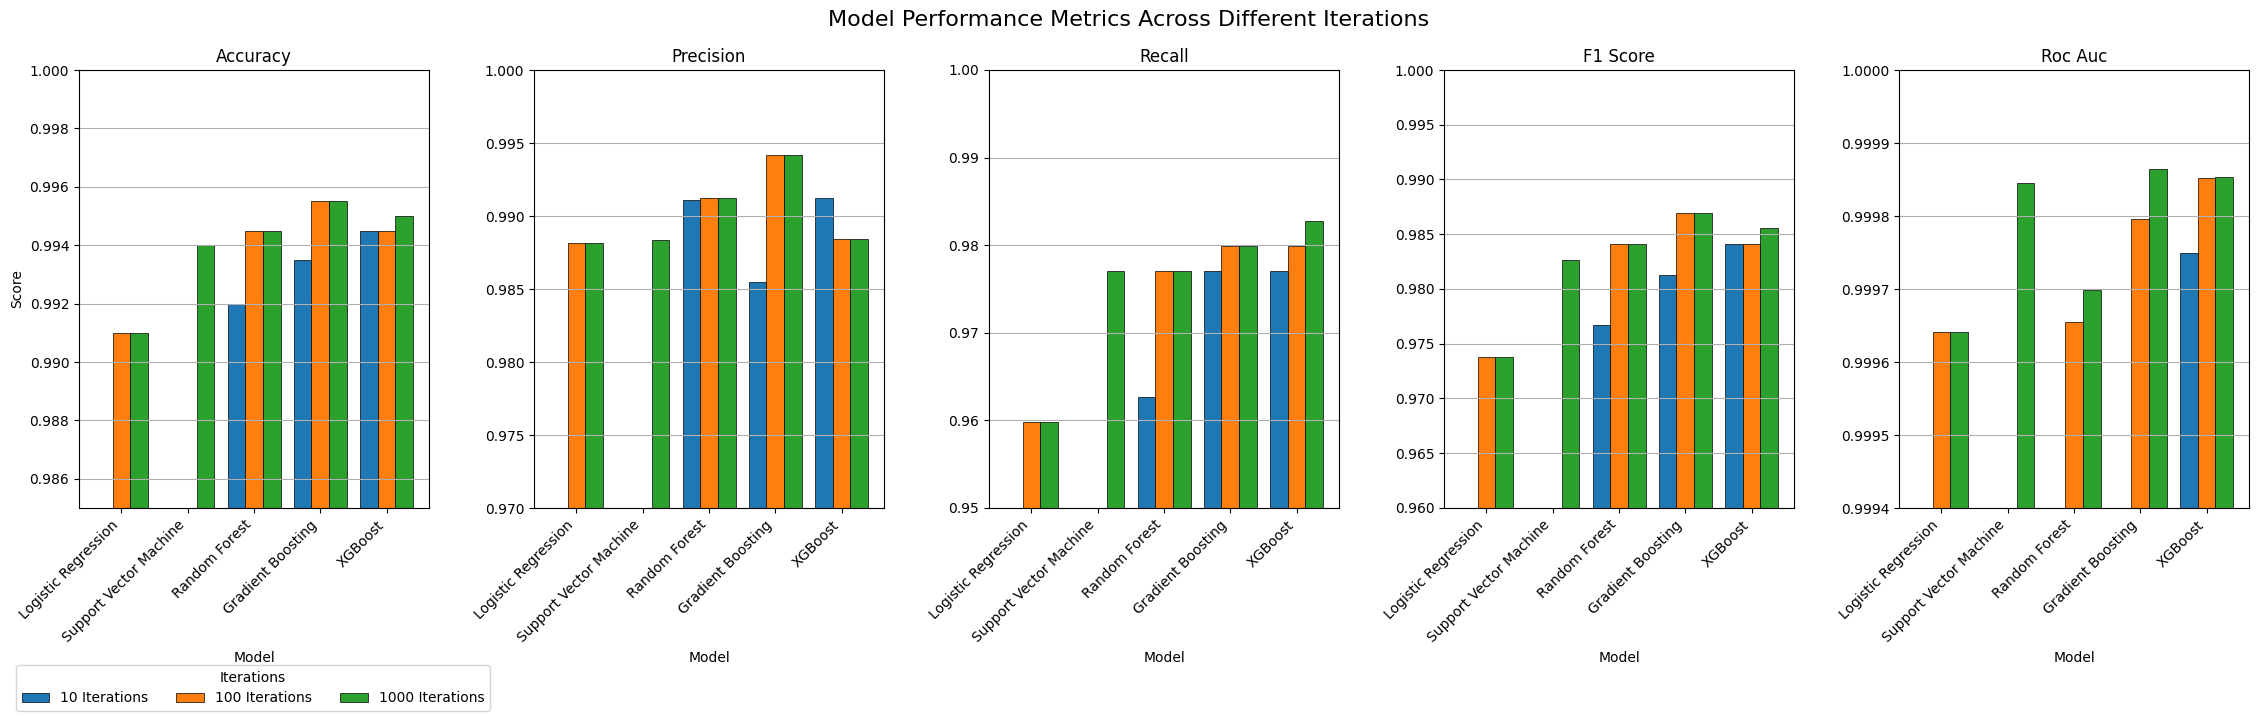

In [98]:
# CASE 1
models = ['Logistic Regression', 'Support Vector Machine', 'Random Forest', 'Gradient Boosting', 'XGBoost']

iteration_values = [10, 100, 1000]

results_df = train_models_store_results(features, target, models, iteration_values)

plot_model_comparison(results_df, iteration_values)

#### We can see that after running {n_iterations, n_estimators} at 10, 100, 1000, that the SVM is a poor model for this application. Also, 10 iterations gets sub-par scores to 100 iterations. Between 100 and 1000 iterations, there is not a large difference and there is the risk of overfitting the training data.

### The best scoring models at 100+ iterations/estimators are the Random Forest, Gradient Boosting, and XGBoost.

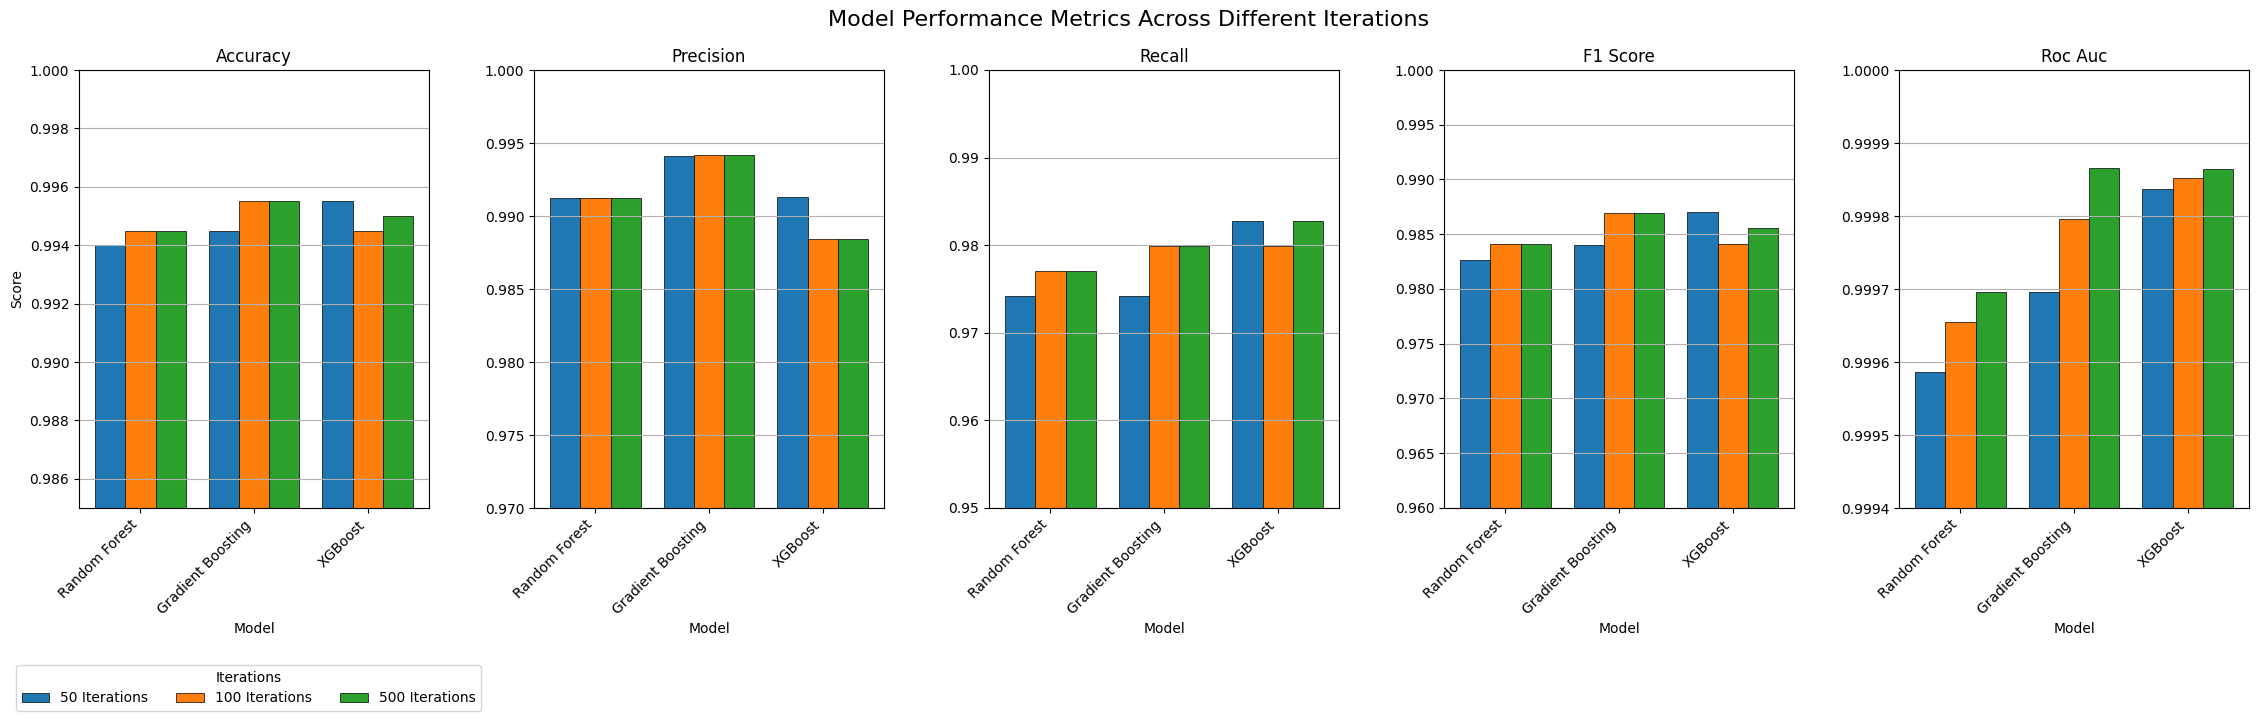

In [99]:
# CASE 2
models = ['Random Forest', 'Gradient Boosting', 'XGBoost']

iteration_values = [50, 100, 500]

results_df = train_models_store_results(features, target, models, iteration_values)

plot_model_comparison(results_df, iteration_values)

#### We can see that 50 for n_iterations / n_estimators is too low to provide top model performance when compared to the other values. The exception is XGBoost which performed the best with 50 iterations. 500 iterations provides no improvement or minimal over 100 iterations/estimators. That count is the best performance for all the models with the least amount of overtraining.

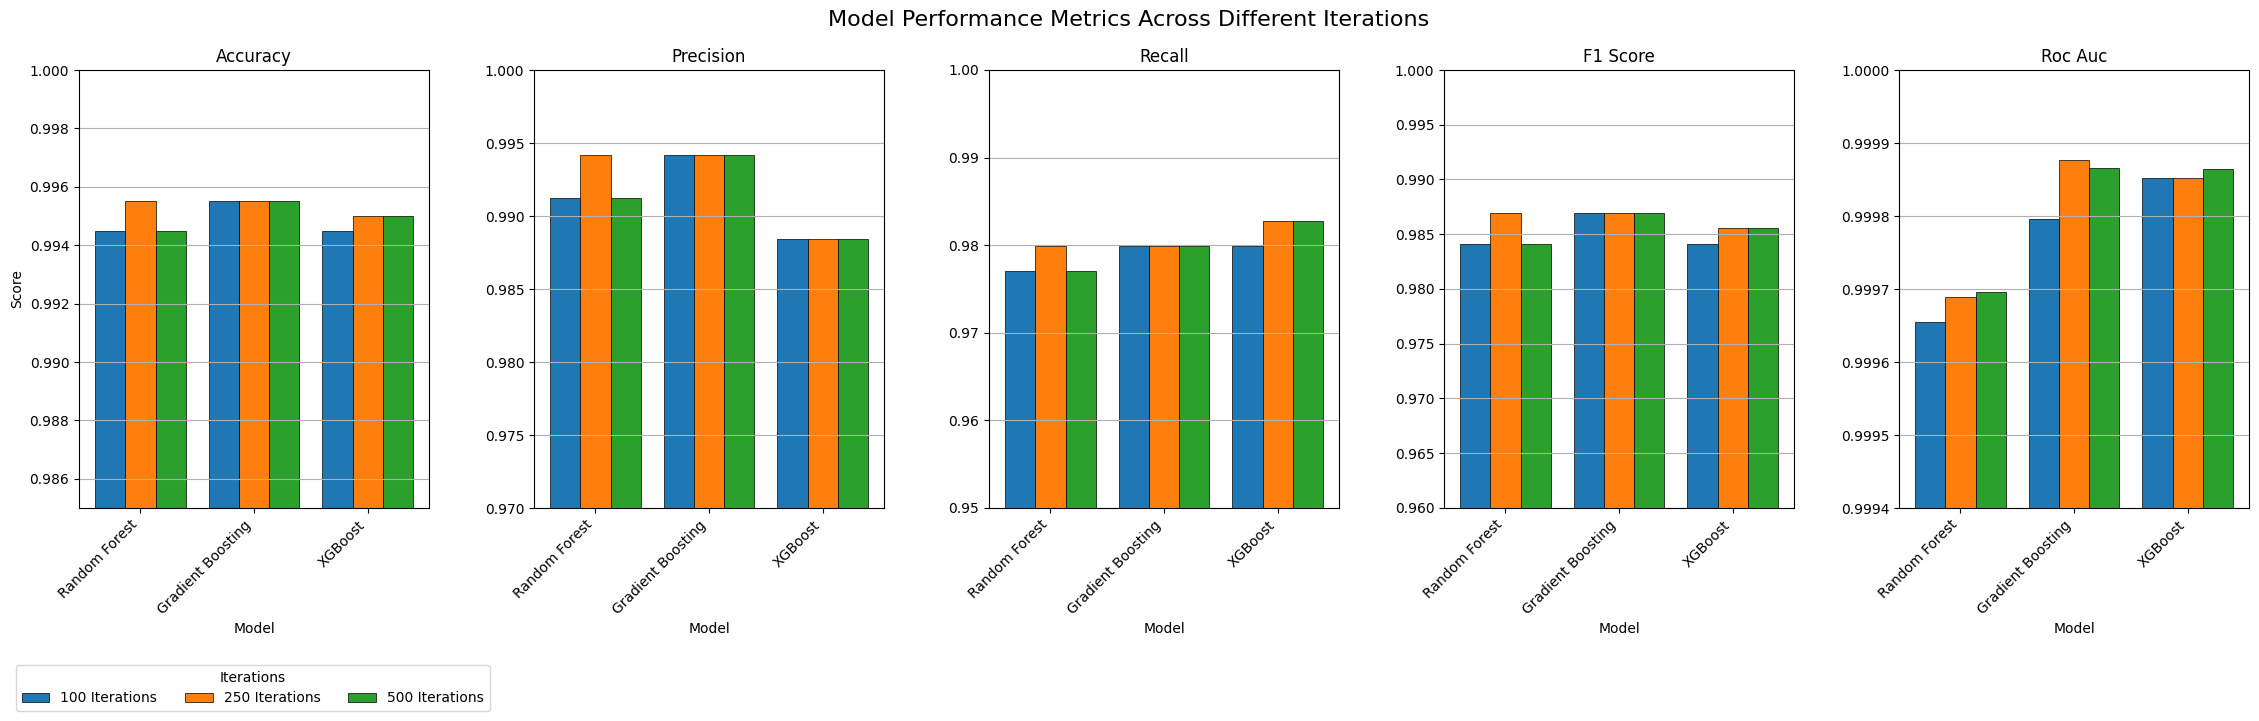

In [100]:
# CASE 3
models = ['Random Forest', 'Gradient Boosting', 'XGBoost']

iteration_values = [100, 250, 500]

results_df = train_models_store_results(features, target, models, iteration_values)

plot_model_comparison(results_df, iteration_values)

#### It appears that the Random Forest benefits the most when going from 100 iterations to 250 for performance. There is no benefit in choosing 500 over 250 iterations for performance. XGBoost also improves from 100 to 250 iterations but plateaus there to 500.

#### At 500 iterations, the Random Forest suffers and declines in performance in 3 of the 5 metrics, suggesting overfit. The Gradient Boosting and XGBoost models don't do consistently better from 250 to 500 iterations so there is no beenfit from the additional training time. 250 iterations outperforms 100 iterations in the Roc Auc for Random Forest and Gradient Boosting and Accuracy for the XGBoost model so that increase is beneficial, although minimal. Also, looking at the orange (250 iterations) category across all models and scores, **Gradient Boosting** is the highest scoring model in the majority of the categories. We will zoom in below.

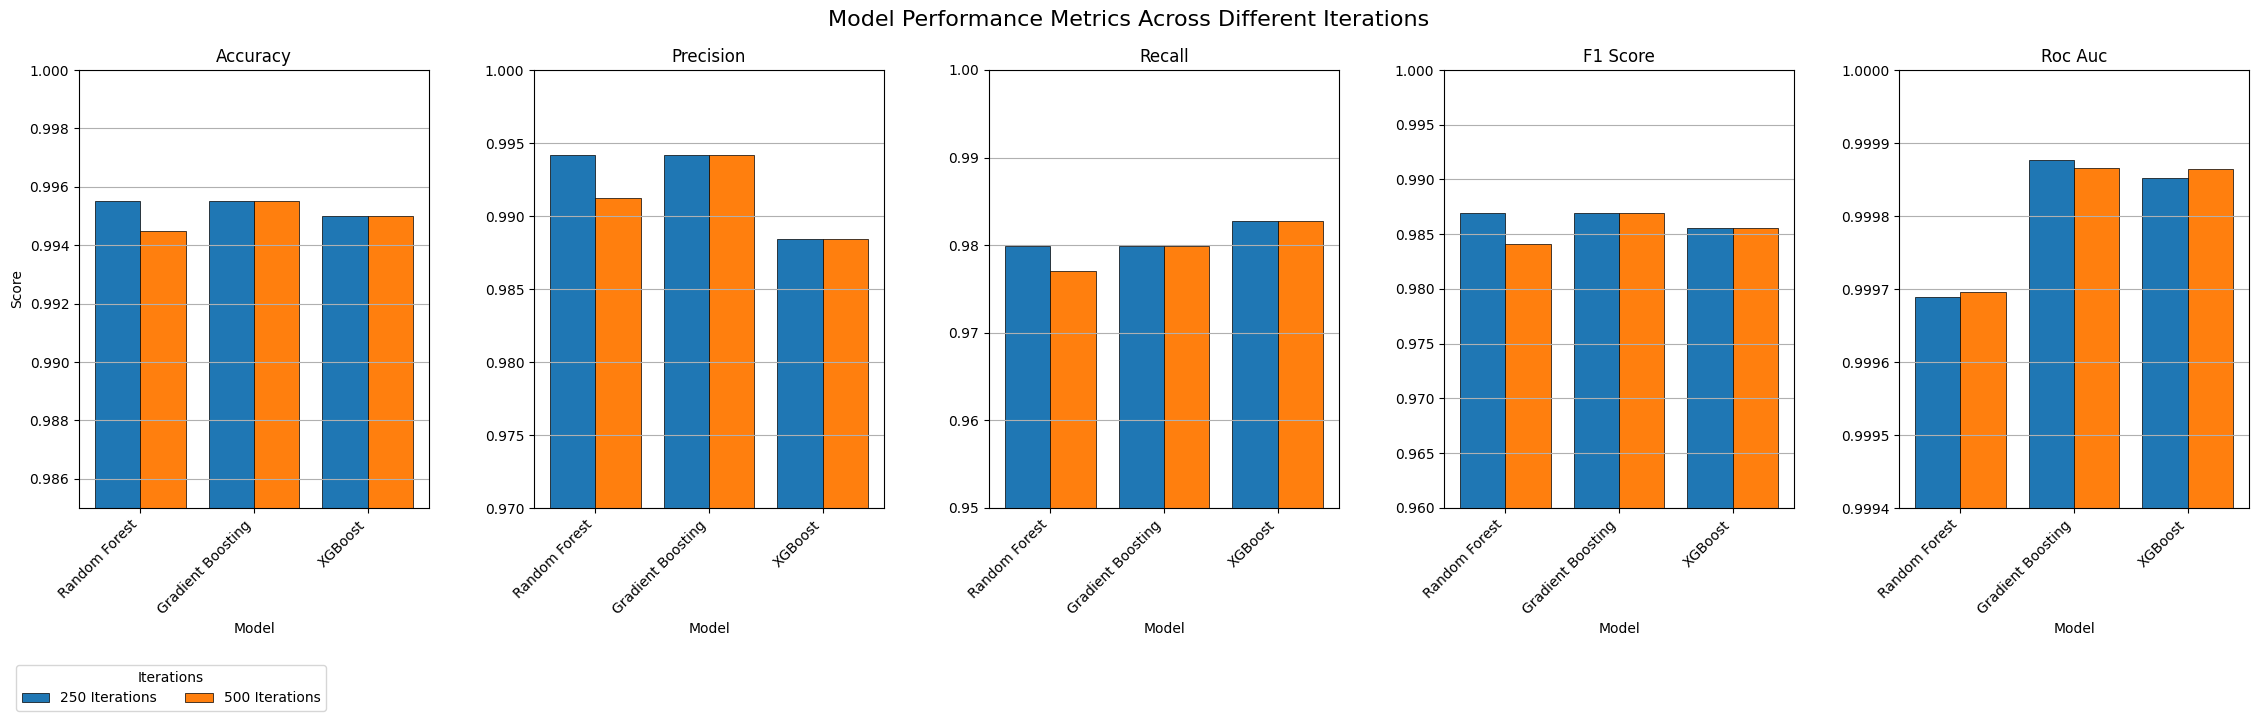

In [101]:
# CASE 4
models = ['Random Forest', 'Gradient Boosting', 'XGBoost']

iteration_values = [250, 500]

results_df = train_models_store_results(features, target, models, iteration_values)

plot_model_comparison(results_df, iteration_values)

#### Random Forest at 500 estimators is weaker than at 250. Performance for all models is generally best at 250 estimators. Looking at performance across models for that count, Random Forest and Gradient Boosting are tied for best in Accuracy and Precision and F1 Score. Gradient Boosting edges of XGBoost slightly in Roc Auc but XGBoost wins in Recall. These scores are all very high and any of these models at 250 estimators would likely perform well, for perspective. The strongest model across all metrics for our use case is **Gradient Boosting** at **250 estimators** so we will select that one for use. Saving the model and variables below:

In [104]:
num_estimators = 250
model_name = 'Gradient Boosting'

model_gboost = GradientBoostingClassifier(n_estimators=num_estimators, random_state=42)
model_gboost.fit(X_train, y_train)

# Predict on test data
y_pred = model_gboost.predict(X_test)
y_pred_proba = model_gboost.predict_proba(X_test)[:,1] if hasattr(model_gboost, 'predict_proba') else None

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division='warn')
recall = recall_score(y_test, y_pred, zero_division='warn')
f1 = f1_score(y_test, y_pred, zero_division='warn')
roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0

result = {
    'model_name': model_name,
    'num_estimators': num_estimators,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc
}

results_df = pd.DataFrame(result, index=[0])

## **Interpreting Model Results**

In [105]:
# Generate predictions on the test data
y_pred_test = model_gboost.predict(X_test)
y_prob_test = model_gboost.predict_proba(X_test)[:,1]

print("How did the test set perform?")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)*100:2.4f} %\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_test)}\n")
print(f"Classification Report:\n{classification_report(y_test, y_pred_test)}\n")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_test):.4f}")

How did the test set perform?
Accuracy: 99.5500 %

Confusion Matrix:
[[1650    2]
 [   7  341]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       0.99      0.98      0.99       348

    accuracy                           1.00      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000


ROC-AUC Score: 0.9999


####  The benchmark accuracy was in the 97 percentile with logistic regression. This > 99.5% accuracy on predictions indicates that Gradient Boosting with 250 estimators is a well-suited model for our use case.
#### The amount of defaults are 348 and non-default profiles are 1652.

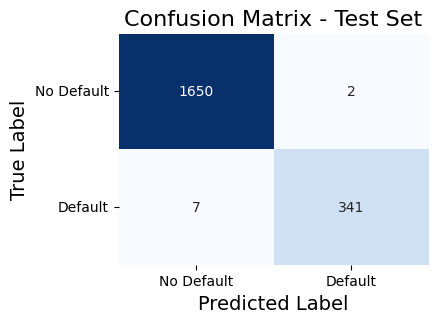

In [107]:
# Confusion Matrix for Test Set
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test Set', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(ticks=[0.5, 1.5], labels=['No Default', 'Default'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Default', 'Default'], rotation=0)
plt.show()

In [128]:
# Extract values from the confusion matrix
tn = conf_matrix_test[0][0] # 1650 correctly predict no default
fp = conf_matrix_test[0][1] # 2 incorrect predict default
fn = conf_matrix_test[1][0] # 7 incorrect predict no default
tp = conf_matrix_test[1][1] # 341 correctly predict default

# Print TP, TN, FP, FN
print(f"True Positives (tp):  {tp}")
print(f"True Negatives (tn):  {tn}")
print(f"False Positives (fp): {fp}")
print(f"False Negatives (fn): {fn}\n")

# Calculate totals
df =  tp + fn  # 348 defaults
ndf = tn + fp  # 1652 no defaults
all_customers = df + ndf # 2000 customers in test set

# Print totals
print(f"Total Defaults:     {df}")
print(f"Total Non-Defaults: {ndf}")
print(f"Total Customers:    {all_customers}\n")

tpr, tnr, ppv, npv = 0.0, 0.0, 0.0, 0.0
# proportion of correctly predicting default, of all defaults
if (tp + fn) > 0: tpr = tp / (tp + fn)

# proportion of correctly predicting no default, of all non-defaults
if (tn + fp) > 0: tnr = tn / (tn + fp)

# proportion of correctly predicting default, of all predictions of default
if (tp + fp) > 0: ppv = tp / (tp + fp)

# proportion of correctly predicting no default, of all predictions of no default
if (tn + fn) > 0: npv = tn / (tn + fn)

# Print performance metrics
print(f"TPR: {100*tpr:.2f}%")
print(f"TNR: {100*tnr:.2f}%")
print(f"PPV: {100*ppv:.2f}%")
print(f"NPV: {100*npv:.2f}%")

True Positives (tp):  341
True Negatives (tn):  1650
False Positives (fp): 2
False Negatives (fn): 7

Total Defaults:     348
Total Non-Defaults: 1652
Total Customers:    2000

TPR: 97.99%
TNR: 99.88%
PPV: 99.42%
NPV: 99.58%


#### **True Positive Rate** (Sensitivity)
Our model correctly predicts borrowers will default roughly 98% of the time. This is a good value but lags the rest of our model's prediction rates.

#### **True Negative Rate** (Specificity)
This is almost perfect at 99.88% and our model is best at predicting correctly borrowers who won't default.

#### **Positive Predictive Value** (Precision)
Of all predictions of default, the model is correct 99.42% of the time. Any bank using the model should look at the loan factors individually, but bad loan flagging will be correct almost always.

#### **Negative Predictive Value**
Of all the predictions of customers not defaulting, the model is 99.58% accurate, so very few customers default if not guessed - this could be to additional variables we aren't tracking or random chance in life.  

#### **Takeaways**
Since the purpose of this project is to calculate expected loss, which is derived partially from if a loan is expected to go bad, as shown by this equation:
```
recovery_rate = 0.10 # 10% standard recovery rate
expected_loss = loan_amt_outstanding * prob_default * (1 - recovery_rate)
```
the comparatively lower `True Positive Rate` to the rest of the model makes me think to reconsider model selection to boost that score.  
The efficacy of a model can be judged by accuracy, precision, recall, f1 score, roc-auc, but looking at the breakdown of the rates above is a level deeper. Although high scores across the board are important, the focus here should be on True Positive Rate, as that  
Looking at the histograms of model comparison above, the raw performance of gradient boosting at 250 estimators is best, but we can do a deep dive on Random Forest and XGBoost to see the quality of the predictions, ideally having highest accuracy in the True Positive Rate metric.

We will try to tune the model to achieve `recall` above 99% and try new models/num estimators if necessary.

#### Although a nearly perfect Roc-Auc score is not necessary to graph, the visual is included above.

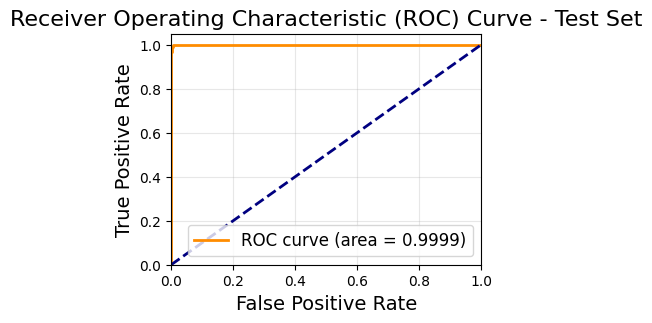

In [106]:
# Compute ROC curve and ROC area for the test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(4,3))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

## Seeking Higher `Recall - True Positive Rate` via Model Tuning

We will adjust the model more with changing the num estimators and performing hyperparameter tuning in search of recall rate above 99%.

### Optimizing **num_estimators**

In [28]:
results = []

for model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    for num_estimators in range(60, 800, 40):

        model = None
        if model_name == 'Random Forest':
            model = RandomForestClassifier(n_estimators=num_estimators, random_state=42)
        elif model_name == 'Gradient Boosting':
            model = GradientBoostingClassifier(n_estimators=num_estimators, random_state=42)
        elif model_name == 'XGBoost':
            model = XGBClassifier(n_estimators=num_estimators, random_state=42, eval_metric='logloss')

        if model is None:
            continue
        model.fit(X_train, y_train)

        model = GradientBoostingClassifier(n_estimators=num_estimators, random_state=42)
        model.fit(X_train, y_train)

        # Predict on test data
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division='warn')
        recall = recall_score(y_test, y_pred, zero_division='warn')
        f1 = f1_score(y_test, y_pred, zero_division='warn')
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0

        result = {
            'model_name': model_name,
            'num_estimators': num_estimators,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc
        }

        results.append(result)

In [37]:
results_df = pd.DataFrame(results)

In [38]:
results_df.describe()

,num_estimators,accuracy,precision,recall,f1_score,roc_auc
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,420.000000,0.995500,0.994169,0.979885,0.986975,0.999852
std,221.036519,0.000327,0.000011,0.001881,0.000959,0.000038
min,60.000000,0.995000,0.994152,0.977011,0.985507,0.999713
25%,220.000000,0.995500,0.994169,0.979885,0.986975,0.999859
50%,420.000000,0.995500,0.994169,0.979885,0.986975,0.999866
75%,620.000000,0.995500,0.994169,0.979885,0.986975,0.999868
max,780.000000,0.996500,0.994203,0.985632,0.989899,0.999876


In [39]:
results_df.sort_values(by='recall', ascending=False, ignore_index=True, inplace=True)
results_df.head(5)

,model_name,num_estimators,accuracy,precision,recall,f1_score,roc_auc
0,Random Forest,380,0.9965,0.994203,0.985632,0.989899,0.999876
1,XGBoost,380,0.9965,0.994203,0.985632,0.989899,0.999876
2,Gradient Boosting,380,0.9965,0.994203,0.985632,0.989899,0.999876
3,Gradient Boosting,420,0.9960,0.994186,0.982759,0.988439,0.999868
4,Random Forest,420,0.9960,0.994186,0.982759,0.988439,0.999868


#### So by purely doing a sweep of the number of estimators, we hit a peak recall rate of 98.56%, which is better than 97.99% as before, but still below our target of > 99% True Positive Rate. This translates to predicting default 343 of 348 times, an improvement of +2. Each of the models achieve that at 380 estimators, which suggests a sweet spot. This is better than the arbitrary 250 I chose before. Our accuracy improves slightly, precision stays the same, f1 score improves - a mix of precision and accuracy, and roc auc stays the same. So out of the box, 98.56% recall appears to be the peak recall for these models given num_estimators +/- 20.

### Tweak **max depth**

In [ ]:
# don't run, and keep these color-coded for reference
while False: \
# RandomForestClassifier
class RandomForestClassifier(ForestClassifier):
    def __init__(self, n_estimators=100, *, criterion='gini', max_depth=None,
                 min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                 max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                 bootstrap=True, oob_score=False, n_jobs=None, random_state=None,
                 verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0,
                 max_samples=None):

# GradientBoostingClassifier initialized as such
class GradientBoostingClassifier(BaseGradientBoostingClassifier):
    def __init__(*, loss='log_loss', learning_rate=0.1, n_estimators=100, subsample=1.0,
                criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                init=None, random_state=None, max_features=None, verbose=0,
                max_leaf_nodes=None, warm_start=False, validation_fraction=0.1,
                n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

# XGBClassifier
class XGBClassifier(BaseXGBoostClassifier):
    def __init__(self, *, objective='binary:logistic', use_label_encoder=False, **kwargs):
        learning_rate: 0.3 (default, but adjustable through kwargs)
        n_estimators: 100 (default, adjustable through kwargs)
        max_depth: 6 (default, adjustable through kwargs)
        min_child_weight: 1 (default, adjustable through kwargs)
        gamma: 0 (default, adjustable through kwargs)
        subsample: 1 (default, adjustable through kwargs)
        colsample_bytree: 1 (default, adjustable through kwargs)
        reg_alpha: 0 (default, adjustable through kwargs)
        reg_lambda: 1 (default, adjustable through kwargs)
        scale_pos_weight: 1 (default, adjustable through kwargs)
        base_score: 0.5 (default, adjustable through kwargs)
        random_state: 0 (default, adjustable through kwargs)

In [48]:
results = []

for model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
     # around 400 estimators seems to be optimal, so trimming beyond +/- 100 for speed
    for num_estimators in range(300, 500+1, 40):
        # default max_depth=3, let's see if increasing depth leads to higher recall rate
        for max_depth in range(3, 9+1, 2):

            model = None
            if model_name == 'Random Forest':
                model = RandomForestClassifier(n_estimators=num_estimators, random_state=42,
                                                max_depth=max_depth)
            elif model_name == 'Gradient Boosting':
                model = GradientBoostingClassifier(n_estimators=num_estimators, random_state=42,
                                                    max_depth=max_depth)

            elif model_name == 'XGBoost':
                model = XGBClassifier(n_estimators=num_estimators, random_state=42, eval_metric='logloss',
                                        max_depth=max_depth)

            if model is None:
                continue
            model.fit(X_train, y_train)

            model = GradientBoostingClassifier(n_estimators=num_estimators, random_state=42)
            model.fit(X_train, y_train)

            # Predict on test data
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division='warn')
            recall = recall_score(y_test, y_pred, zero_division='warn')
            f1 = f1_score(y_test, y_pred, zero_division='warn')
            roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0

            result = {
                'model_name': model_name,
                'max_depth': max_depth,
                'num_estimators': num_estimators,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc
            }

            results.append(result)

In [58]:
results_df = pd.DataFrame(results)

In [61]:
results_df_recall = results_df.sort_values(by='recall', ascending=False, ignore_index=True)
results_df_recall.head(5)

,model_name,max_depth,num_estimators,accuracy,precision,recall,f1_score,roc_auc
0,XGBoost,9,380,0.9965,0.994203,0.985632,0.989899,0.999876
1,Random Forest,3,380,0.9965,0.994203,0.985632,0.989899,0.999876
2,XGBoost,7,380,0.9965,0.994203,0.985632,0.989899,0.999876
3,XGBoost,5,380,0.9965,0.994203,0.985632,0.989899,0.999876
4,XGBoost,3,380,0.9965,0.994203,0.985632,0.989899,0.999876
5,Gradient Boosting,3,380,0.9965,0.994203,0.985632,0.989899,0.999876
6,Random Forest,9,380,0.9965,0.994203,0.985632,0.989899,0.999876
7,Random Forest,7,380,0.9965,0.994203,0.985632,0.989899,0.999876
8,Random Forest,5,380,0.9965,0.994203,0.985632,0.989899,0.999876
9,Gradient Boosting,5,380,0.9965,0.994203,0.985632,0.989899,0.999876


#### Changing max_depth didn't improve recall. It confirms that num_estimators at 380 is strongest and this time XGBoost at all levels takes the top spots. Classification of defaults stalls at 343/348.

### Tweak **learning rate** for gradient boost models

In [64]:
results = []

for model_name in ['Gradient Boosting', 'XGBoost']:
    for num_estimators in [380]:
        # default max_depth=3, let's see if increasing depth leads to higher recall rate
        for learning_rate in range(5, 35+1, 5):
            learning_rate *= 0.01

            model = None
            if model_name == 'Gradient Boosting':
                model = GradientBoostingClassifier(n_estimators=num_estimators, random_state=42,
                                                    learning_rate=learning_rate)

            elif model_name == 'XGBoost':
                model = XGBClassifier(n_estimators=num_estimators, random_state=42, eval_metric='logloss',
                                        learning_rate=learning_rate)

            if model is None:
                continue
            model.fit(X_train, y_train)

            model = GradientBoostingClassifier(n_estimators=num_estimators, random_state=42)
            model.fit(X_train, y_train)

            # Predict on test data
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division='warn')
            recall = recall_score(y_test, y_pred, zero_division='warn')
            f1 = f1_score(y_test, y_pred, zero_division='warn')
            roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0

            result = {
                'model_name': model_name,
                'learning_rate': learning_rate,
                'num_estimators': num_estimators,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc
            }

            results.append(result)

In [65]:
results_df = pd.DataFrame(results)

In [67]:
results_df_recall = results_df.sort_values(by='recall', ascending=False, ignore_index=True)
results_df_recall.head(10)

,model_name,learning_rate,num_estimators,accuracy,precision,recall,f1_score,roc_auc
0,Gradient Boosting,0.05,380,0.9965,0.994203,0.985632,0.989899,0.999876
1,Gradient Boosting,0.10,380,0.9965,0.994203,0.985632,0.989899,0.999876
2,Gradient Boosting,0.15,380,0.9965,0.994203,0.985632,0.989899,0.999876
3,Gradient Boosting,0.20,380,0.9965,0.994203,0.985632,0.989899,0.999876
4,Gradient Boosting,0.25,380,0.9965,0.994203,0.985632,0.989899,0.999876
5,Gradient Boosting,0.30,380,0.9965,0.994203,0.985632,0.989899,0.999876
6,Gradient Boosting,0.35,380,0.9965,0.994203,0.985632,0.989899,0.999876
7,XGBoost,0.05,380,0.9965,0.994203,0.985632,0.989899,0.999876
8,XGBoost,0.10,380,0.9965,0.994203,0.985632,0.989899,0.999876
9,XGBoost,0.15,380,0.9965,0.994203,0.985632,0.989899,0.999876


#### Changing `learning rate` had no effect.

### Tweak

In [72]:
from sklearn.model_selection import GridSearchCV

# Define separate parameter grids for each model
param_grid_rf = {
    'n_estimators': [380],
    'min_samples_split': [2, 5, 10],
    'max_depth': [3],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None], # This is valid for RandomForest
    'criterion': ['gini', 'entropy'],
    'random_state': [42]
}

# class_weight not a thing for gradient boosting models
param_grid_gb = {
    'n_estimators': [380],
    'min_samples_split': [2, 5, 10],
    'max_depth': [3],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['friedman_mse', 'squared_error'],  # Use valid criteria for GradientBoosting
    'random_state': [42]
}

param_grid_xgb = {
    'n_estimators': [380],
    'min_samples_split': [2, 5, 10],
    'max_depth': [3],
    'max_features': ['sqrt', 'log2', None],
    'scale_pos_weight': [1, 3, 5],  # Example values for scale_pos_weight
    'random_state': [42]
}

# save results
results = []
for model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:

    grid_search = None
    if model_name == 'Random Forest':
        grid_search = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring='recall', cv=5, verbose=2, n_jobs=-1)
    elif model_name == 'Gradient Boosting':
        grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, scoring='recall', cv=5, verbose=2, n_jobs=-1)
    elif model_name == 'XGBoost':
        grid_search = GridSearchCV(XGBClassifier(), param_grid_xgb, scoring='recall', cv=5, verbose=2, n_jobs=-1)

    if grid_search is None:
        continue

    # cv=5 for 5-fold cross-validation, n_jobs=-1 to use all available cores
    grid_search.fit(X_train, y_train)

    results.append({
        'model_name': model_name,
        'best_params': grid_search.best_params_,
        'best_recall_score': grid_search.best_score_
    })

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [73]:
results_df_fits = pd.DataFrame(results)

In [74]:
results_df_fits.sort_values(by='best_recall_score', ascending=False, ignore_index=True)
results_df_fits.head(5)

,model_name,best_params,best_recall_score
0,Random Forest,"{'class_weight': 'balanced', 'criterion': 'ent...",0.997338
1,Gradient Boosting,"{'criterion': 'friedman_mse', 'max_depth': 3, ...",0.987351
2,XGBoost,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",0.996007


#### This is exciting as we have the grid search parameter-optimized models `Random Forest` and `XGBoost` hitting at or close to 347/348 correct default predictions. Averaged over the cross-validation of k=5 folds, the 99.60% for `XGBoost` implies that the it is closer to getting 347 predictions correct - than 346 - out of 348 ideally. The `Random Forest` is dead on average 347/348 correct predictions. These results are what we have been seeking. To decide between models, since the recall scores are about the same, I'll look at the other 2nd-order priorities such as accuracy and precision to determine the best model for loan defaults.

In [75]:
rf_best_params = results_df_fits.loc[0, 'best_params']
rf_best_params

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 380,
 'random_state': 42}

In [76]:
xgb_best_params = results_df_fits.loc[1, 'best_params']
xgb_best_params

{'criterion': 'friedman_mse',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 380,
 'random_state': 42}

In [77]:
# Random Forest with ideal parameters
model_rf = RandomForestClassifier(**rf_best_params)
model_rf.fit(X_train, y_train)

# predict
y_pred_rf = model_rf.predict(X_test)
y_pred_rf_proba = model_rf.predict_proba(X_test)[:,1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, zero_division='warn')
recall_rf = recall_score(y_test, y_pred_rf, zero_division='warn')
f1_rf = f1_score(y_test, y_pred_rf, zero_division='warn')
roc_auc_rf = roc_auc_score(y_test, y_pred_rf_proba) if y_pred_rf_proba is not None else 0

result_df_rf_scores = pd.DataFrame({
    'accuracy': [accuracy_rf],
    'precision': [precision_rf],
    'recall': [recall_rf],
    'f1_score': [f1_rf],
    'roc_auc': [roc_auc_rf]
})

In [78]:
# XGBClassifier with ideal parameters
model_xgb = XGBClassifier(**xgb_best_params)
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)
y_pred_xgb_proba = model_xgb.predict_proba(X_test)[:,1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, zero_division='warn')
recall_xgb = recall_score(y_test, y_pred_xgb, zero_division='warn')
f1_xgb = f1_score(y_test, y_pred_xgb, zero_division='warn')
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb_proba) if y_pred_xgb_proba is not None else 0

result_df_xgb_scores = pd.DataFrame({
    'accuracy': [accuracy_xgb],
    'precision': [precision_xgb],
    'recall': [recall_xgb],
    'f1_score': [f1_xgb],
    'roc_auc': [roc_auc]
})

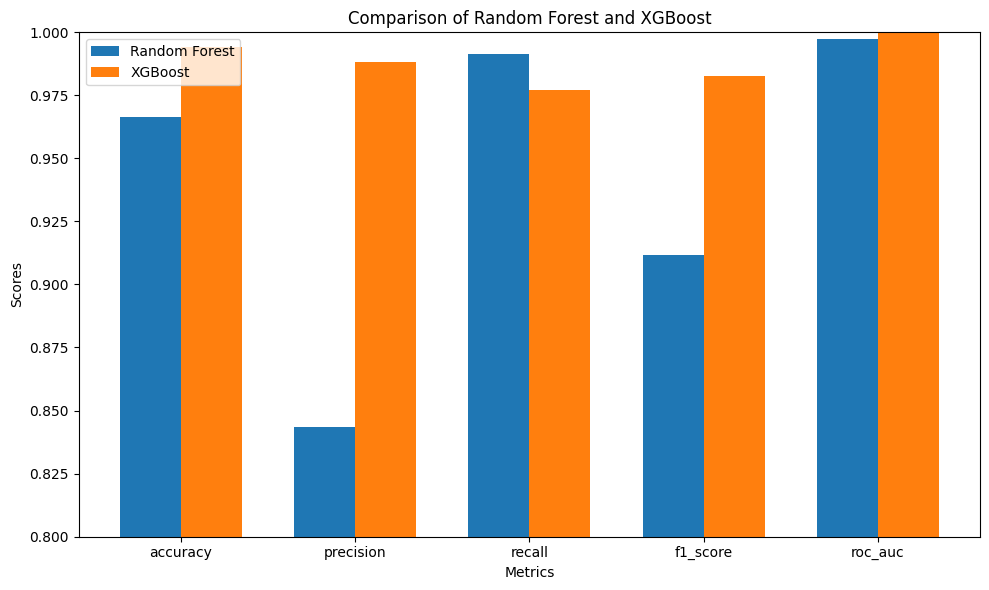

In [85]:
# score all scores for random forest and xgboost in comparison
result_df_scores = pd.concat([result_df_rf_scores, result_df_xgb_scores], axis=0, ignore_index=True)
result_df_scores.index = ['Random Forest', 'XGBoost']
# result_df_scores

metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
x = np.arange(len(metrics))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Random Forest and XGBoost
bars_rf = ax.bar(x - width/2, result_df_scores.loc['Random Forest', metrics], width, label='Random Forest')
bars_xgb = ax.bar(x + width/2, result_df_scores.loc['XGBoost', metrics], width, label='XGBoost')

ax.set_ylim(0.8, 1.0)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Random Forest and XGBoost')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

#### The XGBoost model has a slightly lower recall score but barely. It dominates in accuracy, precision, and f1 score naturally (combination of acc and prec.). The precision of the Random Forest model is the worst of any so far so it is good we checked the chart. The best model for borrower risk therefore is XGBoost with 99.60% recall and great scores in all the other categories as well.